# GIS with ![Python](https://www.python.org/static/community_logos/python-logo-inkscape.svg) and ![IPython](https://ipython.org/_static/IPy_header.png) 

# Part III: Data Munging...Combining GIS with Other Tools

# Set-up our environment as before

Let's import the packages we will use and set the paths for outputs.

In [1]:
# Let's import pandas and some other basic packages we will use 
from __future__ import division

import pandas as pd
import numpy as np
import os, sys

# GIS packages
import geopandas as gpd
from geopandas.tools import overlay
from shapely.geometry import Polygon, Point
import georasters as gr
# Alias for Geopandas
gp = gpd

# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

%pylab --no-import-all
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions for plotting
def center_wrap(text, cwidth=32, **kw):
    '''Center Text (to be used in legend)'''
    lines = text
    #lines = textwrap.wrap(text, **kw)
    return "\n".join(line.center(cwidth) for line in lines)

def MyChloropleth(mydf, myfile='', myvar='',
                  mylegend='',
                  k=5,
                  extent=[-180, -90, 180, 90],
                  bbox_to_anchor=(0.2, 0.5),
                  edgecolor='white', facecolor='lightgray',
                  scheme='FisherJenks', bins=None, pct=None,
                  legend_labels=None,
                  save=True,
                  percent=False,
                  cmap='Reds',
                  **kwargs):
    # Chloropleth
    # Color scheme
    if scheme=='EqualInterval':
        scheme = mc.EqualInterval(mydf[myvar], k=k)
    elif scheme=='Quantiles':
        scheme = mc.Quantiles(mydf[myvar], k=k)
    elif scheme=='BoxPlot':
        scheme = mc.BoxPlot(mydf[myvar], k=k)
    elif scheme=='FisherJenks':
        scheme = mc.FisherJenks(mydf[myvar], k=k)
    elif scheme=='FisherJenksSampled':
        scheme = mc.FisherJenksSampled(mydf[myvar], k=k)
    elif scheme=='HeadTailBreaks':
        scheme = mc.HeadTailBreaks(mydf[myvar], k=k)
    elif scheme=='JenksCaspall':
        scheme = mc.JenksCaspall(mydf[myvar], k=k)
    elif scheme=='JenksCaspallForced':
        scheme = mc.JenksCaspallForced(mydf[myvar], k=k)
    elif scheme=='JenksCaspallSampled':
        scheme = mc.JenksCaspallSampled(mydf[myvar], k=k)
    elif scheme=='KClassifiers':
        scheme = mc.KClassifiers(mydf[myvar], k=k)
    elif scheme=='Percentiles':
        scheme = mc.Percentiles(mydf[myvar], pct=pct)
    elif scheme=='UserDefined':
        scheme = mc.UserDefined(mydf[myvar], bins=bins)
    
    if legend_labels is None:
        # Format legend
        upper_bounds = scheme.bins
        # get and format all bounds
        bounds = []
        for index, upper_bound in enumerate(upper_bounds):
            if index == 0:
                lower_bound = mydf[myvar].min()
            else:
                lower_bound = upper_bounds[index-1]
            # format the numerical legend here
            if percent:
                bound = f'{lower_bound:.0%} - {upper_bound:.0%}'
            else:
                bound = f'{float(lower_bound):,.0f} - {float(upper_bound):,.0f}'
            bounds.append(bound)
        legend_labels = bounds
    #Plot
    ax = gplt.choropleth(
        mydf, hue=myvar, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        cmap=cmap, legend=True,
        scheme=scheme,
        legend_kwargs={'bbox_to_anchor': bbox_to_anchor,
                       'frameon': True,
                       'title':mylegend,
                       },
        legend_labels = legend_labels,
        figsize=(24, 16),
        rasterized=True,
    )
    gplt.polyplot(
        countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=edgecolor, facecolor=facecolor,
        ax=ax,
        rasterized=True,
        extent=extent,
    )
    if save:
        plt.savefig(pathgraphs + myfile + '_' + myvar +'.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '_' + myvar +'.png', dpi=300, bbox_inches='tight')
    pass


In [3]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

# Let's plot the countries for which Colombian citizens do not require visas

The Colombian Cancillery's website has a list with visa requirements for colombians. Let's use it to map countries for which visas are not required. Below is the [link to the information](https://www.cancilleria.gov.co/sites/default/files/FOTOS2020/relacion_de_paises_que_exigen_o_no_visas_a_colombianos_17-04-2020.pdf'). The problem is that it is a pdf file. Let's open the website and check it out

In [4]:
# Import display options for showing websites
from IPython.display import IFrame

url = 'https://www.cancilleria.gov.co/sites/default/files/FOTOS2020/relacion_de_paises_que_exigen_o_no_visas_a_colombianos_17-04-2020.pdf'
IFrame(url, width=800, height=400)

## Roadblock

Someone forgot to make our life easy and made the data available in a ``pdf``.

<img src="../images/pics/fun/CalvinHobbesProblem.png" alt="Only Human?" width="250"/><img src="../images/pics/fun/WhatShallWeDo.jpg" alt="What Shall We Do now?" width="250"/>

## Luckily ``python`` has tools to deal with this. 

<img src="../images/pics/fun/CalvinHobbesNew.jpg" alt="New" width="250"/>

So let's download it, save it to disk and use these tools to process the pdf into a ``pandas.DataFrame``.


In [5]:
# Import package for downloading internet content and save it to file
import requests

url = 'https://www.cancilleria.gov.co/sites/default/files/FOTOS2020/relacion_de_paises_que_exigen_o_no_visas_a_colombianos_17-04-2020.pdf'
response = requests.get(url)
with open(pathout + 'visas.pdf', 'wb') as f:
    f.write(response.content)

In [6]:
# Import package to read pdf tables
import camelot
visas = camelot.read_pdf(pathout + 'visas.pdf', pages='1-7')

Let's explore the visas object

In [7]:
visas

<TableList n=7>

So there are 7 tables in visas. What does Table 1 have?

In [8]:
visas[0]

<Table shape=(28, 3)>

In [9]:
visas[0].df

,0,1,2
0,MINISTERIO DE RELACIONES EXTERIORES DE COLOMBIA,,
1,"DIRECCION DE ASUNTOS MIGRATORIOS, CONSULARES Y...",,
2,COORDINACION DE VISAS E INMIGRACION,,
3,Estados y territorios que exigen o NO visas a ...,,
4,EXIGEN VISA A,,
5,PAIS,SI,NO
6,Afganistán,X,
7,Albania,,X
8,Alemania,,X
9,Andorra,,X


Ok, let's concatenate all these ``pandas`` dataframes.

In [10]:
visadf = pd.concat([i.df for i in visas])
visadf

,0,1,2
0,MINISTERIO DE RELACIONES EXTERIORES DE COLOMBIA,,
1,"DIRECCION DE ASUNTOS MIGRATORIOS, CONSULARES Y...",,
2,COORDINACION DE VISAS E INMIGRACION,,
3,Estados y territorios que exigen o NO visas a ...,,
4,EXIGEN VISA A,,
...,...,...,...
20,Taiwan,X Visa electrónica,
21,Wallis y Futuna (Francia),,X
22,,,
23,Actualización 21 -10-2019,,


## We need to correct the header

In [11]:
visadf.columns = visadf.iloc[5]

In [12]:
visadf.head(10)

5,PAIS,SI,NO
0,MINISTERIO DE RELACIONES EXTERIORES DE COLOMBIA,,
1,"DIRECCION DE ASUNTOS MIGRATORIOS, CONSULARES Y...",,
2,COORDINACION DE VISAS E INMIGRACION,,
3,Estados y territorios que exigen o NO visas a ...,,
4,EXIGEN VISA A,,
5,PAIS,SI,NO
6,Afganistán,X,
7,Albania,,X
8,Alemania,,X
9,Andorra,,X


In [13]:
visadf = visadf.iloc[6:].copy()

In [14]:
visadf.columns.name = ''

In [15]:
visadf.head(10)

,PAIS,SI,NO
6,Afganistán,X,
7,Albania,,X
8,Alemania,,X
9,Andorra,,X
10,Angola,X,
11,Antigua y Barbuda,,X
12,Arabia Saudita,X,
13,Argelia,X,
14,Argentina,,X
15,Armenia,,


Let's code SI (YES) as 1 and NO as 0

In [16]:
visadf['visa_req'] = visadf.SI.map({'X':1, '':0})

Let's check whether things were mapped correctly

In [17]:
visadf.loc[visadf.visa_req.isna()]

,PAIS,SI,NO,visa_req
16,Australia,X X,,NaN
18,Azerbaiyán,X (Visa electrónica),,NaN
20,Bahréin,X (visa a la llegada y visa electrónica),,NaN
26,Belarús,X X,,NaN
6,Burundi,X X X,,NaN
8,Cabo Verde,X (Visa a la llegada),,NaN
9,Camboya,X (Visa a la llegada),,NaN
11,Canadá,X X X,,NaN
18,Congo,X X X,,NaN
22,Costa de Marfil,X X,,NaN


In [18]:
IFrame(url, width=800, height=400)

In [19]:
visadf.loc[(visadf.SI=='X X') | (visadf.SI.shift(1)=='X X')  | (visadf.SI.shift(-1)=='X X')]

,PAIS,SI,NO,visa_req
15,Armenia,,,0.0
16,Australia,X X,,NaN
17,Austria,,X,0.0
25,Benin,,,0.0
26,Belarús,X X,,NaN
27,Bolivia,,X,0.0
21,Corea República Popular Dem.,,,0.0
22,Costa de Marfil,X X,,NaN
23,Costa Rica,X,A titulares de Visa de EE UU o Schengen vigen...,1.0
4,Etiopía,,,0.0


In [20]:
visadf.loc[(visadf.SI=='X X X') | (visadf.SI.shift(1)=='X X X')  | (visadf.SI.shift(-1)=='X X X')]

,PAIS,SI,NO,visa_req
5,Burkina Faso,,,0.0
6,Burundi,X X X,,NaN
7,Bután,,,0.0
10,Camerún,,,0.0
11,Canadá,X X X,,NaN
12,Chad,,,0.0
17,Comoras,,,0.0
18,Congo,X X X,,NaN
19,Congo República Democrática,,,0.0
16,Guinea,,,0.0


Ok it seems we have two types of errors. First, notince that sometimes the type of visa is defined, e.g., Azerbayán. Second, the OCR software has mixed some rows, so that now we have XX, XXX, etc. Looking at the pdf it seems this is due to assigning an X from a previous row to the current row ("X X") or from both the previous and next ("X X X"). Let's try to correct these errors programatically (obviously sometimes it may just be faster and better to export the dataframe, correct it by hand snd then load the corrected one, but we're here to learn, right?).

First, let's replace the repeated X with what seems to be the correct data.

**X X**

In [21]:
visadf.loc[(visadf.SI=='X X') | (visadf.SI.shift(-1)=='X X'), 'visa_req'] = 1
visadf.loc[(visadf.SI=='X X') | (visadf.SI.shift(-1)=='X X')]

,PAIS,SI,NO,visa_req
15,Armenia,,,1.0
16,Australia,X X,,1.0
25,Benin,,,1.0
26,Belarús,X X,,1.0
21,Corea República Popular Dem.,,,1.0
22,Costa de Marfil,X X,,1.0
4,Etiopía,,,1.0
5,Fiji,X X,,1.0
12,Ghana,,,1.0
13,Granada,X X,,1.0


**X X X**

In [22]:
visadf.loc[(visadf.SI=='X X X') | (visadf.SI.shift(1)=='X X X')  | (visadf.SI.shift(-1)=='X X X'), 'visa_req'] =1
visadf.loc[(visadf.SI=='X X X') | (visadf.SI.shift(1)=='X X X')  | (visadf.SI.shift(-1)=='X X X')]

,PAIS,SI,NO,visa_req
5,Burkina Faso,,,1.0
6,Burundi,X X X,,1.0
7,Bután,,,1.0
10,Camerún,,,1.0
11,Canadá,X X X,,1.0
12,Chad,,,1.0
17,Comoras,,,1.0
18,Congo,X X X,,1.0
19,Congo República Democrática,,,1.0
16,Guinea,,,1.0


**X X X X**

In [23]:
visadf.loc[(visadf.SI=='X X X X') | (visadf.SI.shift(1)=='X X X X')  | (visadf.SI.shift(-1)=='X X X X') | (visadf.SI.shift(2)=='X X X X')  | (visadf.SI.shift(-2)=='X X X X')  | (visadf.SI.shift(-3)=='X X X X')]

,PAIS,SI,NO,visa_req
17,Tanzania,X Visa a la llegada,,NaN
18,Tayikistán,,,0.0
19,Timor Oriental,,,0.0
20,Togo,X X X X,,NaN
21,Tonga,,,0.0
22,Trinidad y Tobago,,X,0.0


In [24]:
visadf.loc[(visadf.SI=='X X X X') | (visadf.SI.shift(1)=='X X X X')  | (visadf.SI.shift(-1)=='X X X X') | (visadf.SI.shift(-2)=='X X X X'), 'visa_req'] = 1
visadf.loc[(visadf.SI=='X X X X') | (visadf.SI.shift(1)=='X X X X')  | (visadf.SI.shift(-1)=='X X X X') | (visadf.SI.shift(-2)=='X X X X')]

,PAIS,SI,NO,visa_req
18,Tayikistán,,,1.0
19,Timor Oriental,,,1.0
20,Togo,X X X X,,1.0
21,Tonga,,,1.0


**X X X X X**

In [25]:
visadf.loc[(visadf.SI=='X X X X X') | (visadf.SI.shift(1)=='X X X X X')  | (visadf.SI.shift(-1)=='X X X X X') | (visadf.SI.shift(-2)=='X X X X X') | (visadf.SI.shift(2)=='X X X X X')]

,PAIS,SI,NO,visa_req
23,India,,,0.0
24,Indonesia,,,0.0
25,Irán,X X X X X,,NaN
26,Iraq,,,0.0
27,Irlanda,,,0.0


In [26]:
visadf.loc[(visadf.SI=='X X X X X') | (visadf.SI.shift(1)=='X X X X X')  | (visadf.SI.shift(-1)=='X X X X X') | (visadf.SI.shift(-2)=='X X X X X') | (visadf.SI.shift(2)=='X X X X X'), 'visa_req'] = 1
visadf.loc[(visadf.SI=='X X X X X') | (visadf.SI.shift(1)=='X X X X X')  | (visadf.SI.shift(-1)=='X X X X X') | (visadf.SI.shift(-2)=='X X X X X') | (visadf.SI.shift(2)=='X X X X X')]

,PAIS,SI,NO,visa_req
23,India,,,1.0
24,Indonesia,,,1.0
25,Irán,X X X X X,,1.0
26,Iraq,,,1.0
27,Irlanda,,,1.0


**X X X X X X**

In [27]:
visadf.loc[(visadf.SI=='X X X X X X') | (visadf.SI.shift(1)=='X X X X X X')  | (visadf.SI.shift(-1)=='X X X X X X') | (visadf.SI.shift(-2)=='X X X X X X') | (visadf.SI.shift(2)=='X X X X X X') | (visadf.SI.shift(-3)=='X X X X X X') | (visadf.SI.shift(3)=='X X X X X X')]

,PAIS,SI,NO,visa_req
6,Siria,,,0.0
7,Somalia,,,0.0
8,Sri Lanka,,,0.0
9,Sudáfrica,X X X X X X,,NaN
10,Sudán del Sur,,,0.0
11,Sudán,,,0.0
12,Suecia,,X,0.0


In [28]:
visadf.loc[(visadf.SI=='X X X X X X') | (visadf.SI.shift(1)=='X X X X X X')  | (visadf.SI.shift(-1)=='X X X X X X') | (visadf.SI.shift(-2)=='X X X X X X') | (visadf.SI.shift(2)=='X X X X X X') | (visadf.SI.shift(-3)=='X X X X X X'), 'visa_req'] = 1
visadf.loc[(visadf.SI=='X X X X X X') | (visadf.SI.shift(1)=='X X X X X X')  | (visadf.SI.shift(-1)=='X X X X X X') | (visadf.SI.shift(-2)=='X X X X X X') | (visadf.SI.shift(2)=='X X X X X X') | (visadf.SI.shift(-3)=='X X X X X X')]

,PAIS,SI,NO,visa_req
6,Siria,,,1.0
7,Somalia,,,1.0
8,Sri Lanka,,,1.0
9,Sudáfrica,X X X X X X,,1.0
10,Sudán del Sur,,,1.0
11,Sudán,,,1.0


Let's also replace visa required for any row that has the word "visa".

In [29]:
visadf.loc[visadf.SI.str.lower().str.find('visa')!=-1]

,PAIS,SI,NO,visa_req
18,Azerbaiyán,X (Visa electrónica),,NaN
20,Bahréin,X (visa a la llegada y visa electrónica),,NaN
8,Cabo Verde,X (Visa a la llegada),,NaN
9,Camboya,X (Visa a la llegada),,NaN
30,Egipto,X (Visa a la llegada),,NaN
1,Kenia,X Visa a la llegada,,NaN
6,Laos República Democrática P,X Visa a la llegada,,NaN
32,Myanmar,X (Visa a la llegada),,NaN
1,Nicaragua,X (visa a la llegada para titulares de visa de...,,NaN
6,Omán,X (Visa de turismo al ingreso a Omán en los pu...,,NaN


In [30]:
visadf.loc[visadf.SI.str.lower().str.find('visa')!=-1, 'visa_req'] = 1
visadf.loc[visadf.SI.str.lower().str.find('visa')!=-1]

,PAIS,SI,NO,visa_req
18,Azerbaiyán,X (Visa electrónica),,1.0
20,Bahréin,X (visa a la llegada y visa electrónica),,1.0
8,Cabo Verde,X (Visa a la llegada),,1.0
9,Camboya,X (Visa a la llegada),,1.0
30,Egipto,X (Visa a la llegada),,1.0
1,Kenia,X Visa a la llegada,,1.0
6,Laos República Democrática P,X Visa a la llegada,,1.0
32,Myanmar,X (Visa a la llegada),,1.0
1,Nicaragua,X (visa a la llegada para titulares de visa de...,,1.0
6,Omán,X (Visa de turismo al ingreso a Omán en los pu...,,1.0


Let's check again

In [31]:
visadf.loc[visadf.visa_req.isna()]

,PAIS,SI,NO,visa_req


Ok, it seems we have coded which countries need and which do not need visa for colombian citizens. Let's analyze this data a bit.

In [32]:
visadf['visa_req_YN'] = visadf.visa_req.map({0:'NO', 1:'YES'})
visadf

,PAIS,SI,NO,visa_req,visa_req_YN
6,Afganistán,X,,1.0,YES
7,Albania,,X,0.0,NO
8,Alemania,,X,0.0,NO
9,Andorra,,X,0.0,NO
10,Angola,X,,1.0,YES
...,...,...,...,...,...
20,Taiwan,X Visa electrónica,,1.0,YES
21,Wallis y Futuna (Francia),,X,0.0,NO
22,,,,0.0,NO
23,Actualización 21 -10-2019,,,0.0,NO


count    219.000000
mean       0.547945
std        0.498836
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: visa_req, dtype: float64

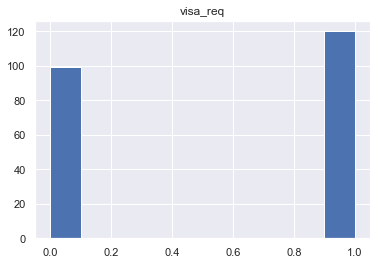

In [33]:
visadf.hist()
visadf.visa_req.describe()

In [34]:
df = visadf.groupby('visa_req_YN').count().reset_index()
df

,visa_req_YN,PAIS,SI,NO,visa_req
0,NO,99,99,99,99
1,YES,120,120,120,120


Text(0, 0.5, 'Number of Countries')

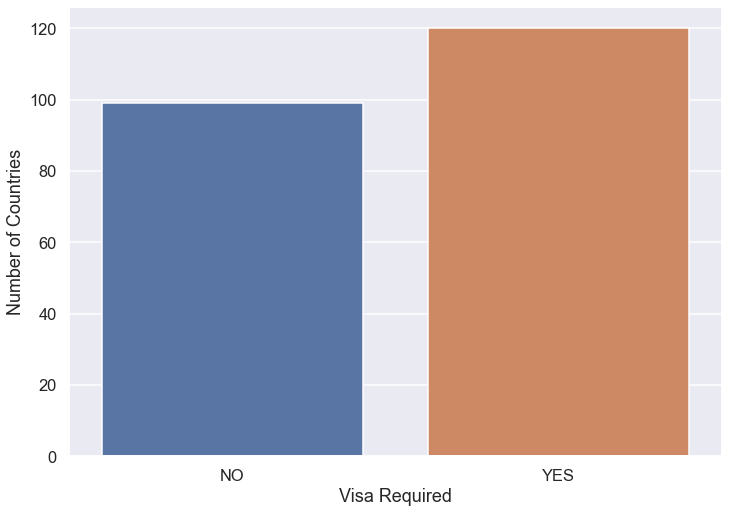

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")
# Plot
fig, ax = plt.subplots()
sns.barplot(x='visa_req_YN', y='visa_req', data=df, alpha=1)
ax.tick_params(axis = 'both', which = 'major')
ax.tick_params(axis = 'both', which = 'minor')
ax.set_xlabel('Visa Required')
ax.set_ylabel('Number of Countries')

Let's try to map these countries. First let's get the Natural Earth shapefile.

In [36]:
import requests
import io

#headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}

url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'
r = requests.get(url, headers=headers)
countries = gp.read_file(io.BytesIO(r.content))
#countries = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip')

In [37]:
countries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ..."
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,None,None,None,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4..."
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796..."
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,Serranilla Bank,SER,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864..."


Luckily there are country names in Spanish. Let's see if we can merge these two data sets.

In [38]:
countries.NAME_ES

0                    Indonesia
1                      Malasia
2                        Chile
3                      Bolivia
4                         Perú
                ...           
253                      Macao
254    Islas Ashmore y Cartier
255                 Bajo Nuevo
256            Isla Serranilla
257           Bajo de Masinloc
Name: NAME_ES, Length: 258, dtype: object

In [39]:
col_visa = countries.merge(visadf, left_on='NAME_ES', right_on='PAIS')

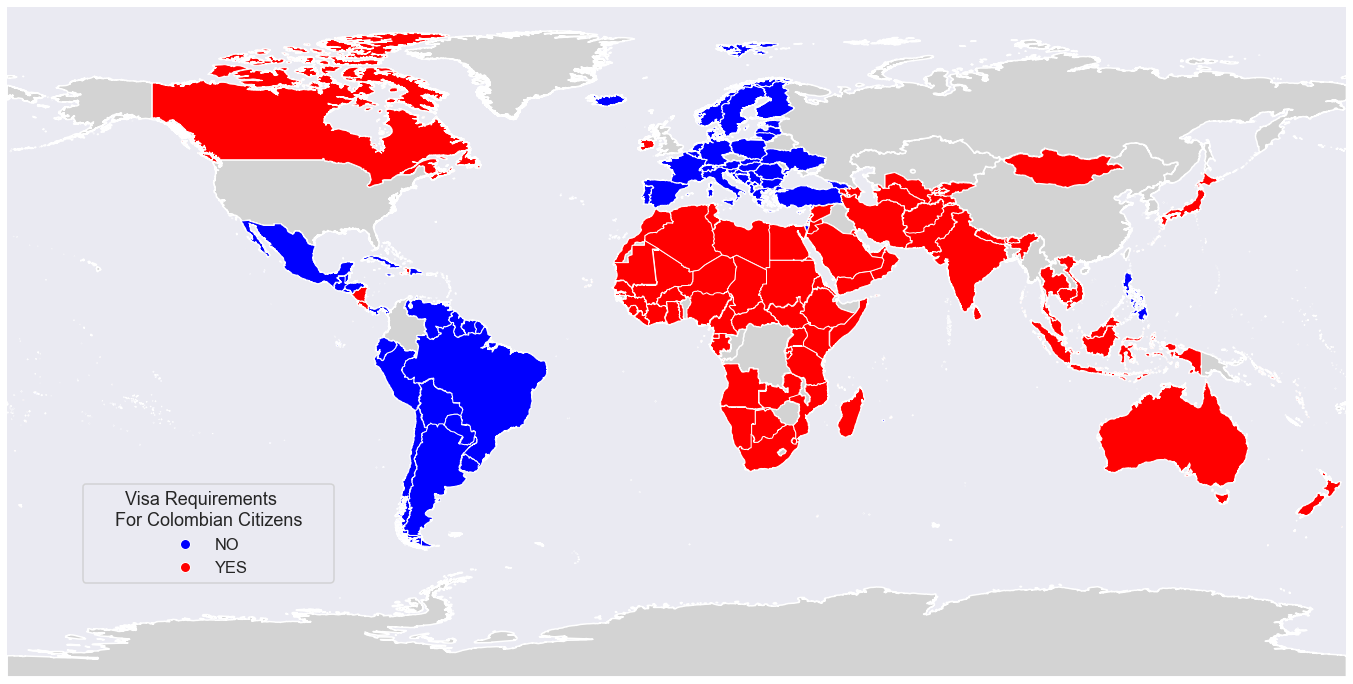

In [40]:
cmap = mpl.colors.ListedColormap(['blue', 'red'])
mylegend = center_wrap(["Visa Requirements", "For Colombian Citizens"], cwidth=32, width=32)
MyChloropleth(mydf=col_visa, myfile='col_visa', myvar='visa_req', mylegend=mylegend, k=1, bbox_to_anchor=(0.25, 0.3),
                  edgecolor='white', facecolor='lightgray', cmap=cmap, scheme='UserDefined', bins=[0,1], legend_labels=['NO', 'YES'],
                  save=False)

So it seems not everything merged correctly

In [41]:
col_visa.shape

(164, 167)

In [42]:
visadf.shape

(219, 5)

In [43]:
col_visa.loc[col_visa.visa_req.isna(), 'NAME_ES'].sort_values()

Series([], Name: NAME_ES, dtype: object)

So we are not linking all countries. This is usually due to symbols like accents and ~, but in this case also because the tail of the data frame includes territories of countries, so their names are non-standard (and OCR may have made some mistakes). 

In [44]:
visadf.tail(25)

,PAIS,SI,NO,visa_req,visa_req_YN
0,OTROS TERRITORIOS,,,0.0,NO
1,Aruba (Países Bajos),,X,0.0,NO
2,Bonaire (Países Bajos),,X,0.0,NO
3,Curazao (Países Bajos),,X,0.0,NO
4,Guadalupe (Francia),,X,0.0,NO
5,Guyana Francesa,,X,0.0,NO
6,Hong Kong (SARG-China),,X Por 90 días,0.0,NO
7,Macao (SARG-China) (*),X Visa a la llegada,,1.0,YES
8,Martinica (Francia),,X,0.0,NO
9,Mayotte (Francia),,X,0.0,NO


Let's correct the country names to improve matching. It's always a good practice to keep the original names.

In [45]:
visadf['PAIS_OR'] = visadf.PAIS

In [46]:
visadf.loc[visadf.PAIS.str.find('(')!=-1, 'PAIS'] = visadf.loc[visadf.PAIS_OR.str.find('(')!=-1, 'PAIS_OR'].apply(lambda x: x[:x.find('(')])
visadf.PAIS = visadf.PAIS.str.strip()

In [47]:
visadf.tail(30)

,PAIS,SI,NO,visa_req,visa_req_YN,PAIS_OR
32,Venezuela,,X,0.0,NO,Venezuela
33,Vietnam,,,1.0,YES,Vietnam
34,Yemen,X X X,,1.0,YES,Yemen
35,Zambia,,,1.0,YES,Zambia
36,Zimbabwe,X,,1.0,YES,Zimbabwe
0,OTROS TERRITORIOS,,,0.0,NO,OTROS TERRITORIOS
1,Aruba,,X,0.0,NO,Aruba (Países Bajos)
2,Bonaire,,X,0.0,NO,Bonaire (Países Bajos)
3,Curazao,,X,0.0,NO,Curazao (Países Bajos)
4,Guadalupe,,X,0.0,NO,Guadalupe (Francia)


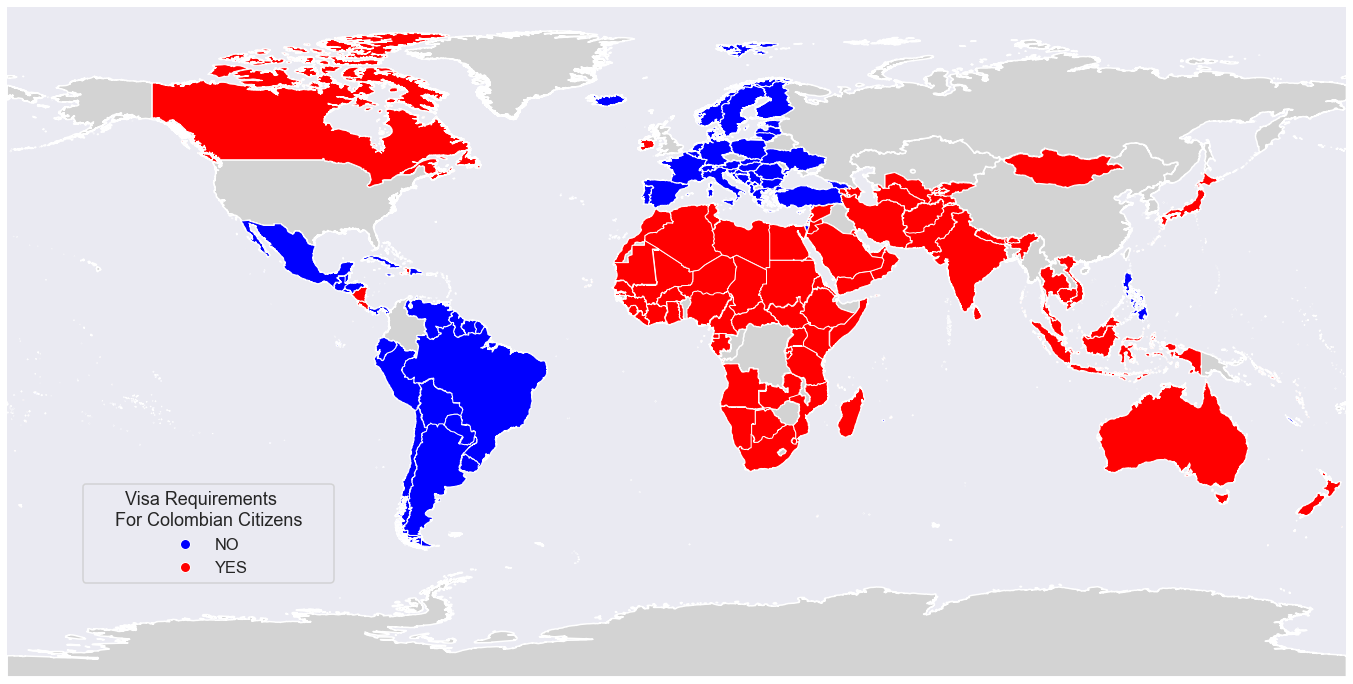

In [48]:
col_visa = countries.merge(visadf, left_on='NAME_ES', right_on='PAIS')
cmap = mpl.colors.ListedColormap(['blue', 'red'])
mylegend = center_wrap(["Visa Requirements", "For Colombian Citizens"], cwidth=32, width=32)
MyChloropleth(mydf=col_visa, myfile='col_visa', myvar='visa_req', mylegend=mylegend, k=1, bbox_to_anchor=(0.25, 0.3),
                  edgecolor='white', facecolor='lightgray', cmap=cmap, scheme='UserDefined', bins=[0,1], legend_labels=['NO', 'YES'],
                  save=False)

In [49]:
col_visa.shape

(170, 168)

Ok, that helped a bit. Let's see what else is different. Let's start by finding which countries are not linked.

In [55]:
miss_countries = list(set(countries.NAME_ES).difference(col_visa.NAME_ES))
#miss_countries.remove(None)
#miss_countries.sort()
miss_visadf = list(set(visadf.PAIS).difference(col_visa.PAIS))
miss_visadf.remove('')
miss_visadf.sort()
print('Misssing countries', miss_countries)
print('')
print('Missing PAIS', miss_visadf)

Misssing countries ['Montserrat', 'Malaui', 'San Cristóbal y Nieves', 'Isla Brasilera', 'República Turca del Norte de Chipre', 'Macedonia del Norte', 'San Bartolomé', 'Jersey', 'República de China', 'Isla Norfolk', 'islas del mar del Coral', 'Islas Pitcairn', 'Somalilandia', 'Ciudad del Vaticano', 'Islas Malvinas', 'Corea del Norte', 'Moldavia', 'Estados Unidos', 'Campo de hielo Patagónico Sur', 'Catar', 'Guinea-Bisáu', 'Bangladés', 'Guam', 'Papúa Nueva Guinea', 'Puerto Rico', 'Isla Santa Elena', 'China', 'Guernsey', 'Bermudas', 'San Pedro y Miquelón', 'Antártida', 'Brunéi', 'Benín', 'Palaos', 'Glaciar de Siachen', 'Territorios Australianos del Océano Índico', 'Corea del Sur', 'Islas Ashmore y Cartier', 'Territorio Británico del Océano Índico', 'Isla Serranilla', 'Anguila', 'San Martín', 'Islas Caimán', 'Colombia', 'Akrotiri', 'Baréin', 'Baikonur', 'Samoa Estadounidense', 'Zimbabue', 'Irak', 'Åland', 'Islas Heard y McDonald', 'República Checa', 'Islas Vírgenes de los Estados Unidos', '

Let's choose one example to see why/how
they differ

In [56]:
countries.loc[countries.NAME_ES.str.find('Congo')!=-1, 'NAME_ES']

30                República del Congo
31    República Democrática del Congo
Name: NAME_ES, dtype: object

In [57]:
visadf.loc[visadf.PAIS.str.find('Congo')!=-1, 'PAIS']

18                          Congo
19    Congo República Democrática
Name: PAIS, dtype: object

OK, so not an easy fix. We can correct by hand the missing ones or perhaps if we can find a way of linking for each missing country in one dataframe the most similar country in the other we may be able to simplify our work. If you google for help you will find e.g., that the package ``difflib`` can help.

In [58]:
# Import package to match text
import difflib

Let's create a dataframe to keep the matches we create between the country name in ``countries`` and ``visadf``.

In [81]:
matches = pd.DataFrame(miss_countries, columns=['countries'])
matches = matches.loc[matches.countries.isna()==False].reset_index(drop=True).copy()
matches

,countries
0,Montserrat
1,Malaui
2,San Cristóbal y Nieves
3,Isla Brasilera
4,República Turca del Norte de Chipre
...,...
82,Gibraltar
83,Islas Turcas y Caicos
84,Niue
85,Lesoto


Now, let's use the ``difflib.get_close_matches`` function to find the closest match to each country name in ``countries`` to ``visadf``.

In [82]:
matches['visadf'] = matches.countries.apply(lambda x: difflib.get_close_matches(x, miss_visadf, cutoff=0.8))
matches.loc[matches.visadf.apply(lambda x: x!=[])]

,countries,visadf
1,Malaui,[Malawi]
16,Moldavia,[Moldova]
19,Catar,[Qatar]
20,Guinea-Bisáu,[Guinea-Bissau]
21,Bangladés,[Bangladesh]
23,Papúa Nueva Guinea,[Papua Nueva Guinea]
32,Benín,[Benin]
41,San Martín,[Saint Martin]
45,Baréin,[Bahréin]
48,Zimbabue,[Zimbabwe]


So it works! Of course now we need to improve matches and try to find as many as we can so we do not have to do it by hand. One way to do it is to keep the correct matches and decrease the cutoff required for a match. 

In [83]:
matches.loc[matches.visadf.apply(lambda x: x!=[] and len(x)==1), 'k'] = 0.8
matches.loc[matches.visadf.apply(lambda x: x!=[] and len(x)==1), 'visadf_matched'] = matches.loc[matches.visadf.apply(lambda x: x!=[] and len(x)==1), 'visadf'].apply(lambda x: x[0])
matches

,countries,visadf,k,visadf_matched
0,Montserrat,[],NaN,NaN
1,Malaui,[Malawi],0.8,Malawi
2,San Cristóbal y Nieves,[],NaN,NaN
3,Isla Brasilera,[],NaN,NaN
4,República Turca del Norte de Chipre,[],NaN,NaN
...,...,...,...,...
82,Gibraltar,[],NaN,NaN
83,Islas Turcas y Caicos,[],NaN,NaN
84,Niue,[],NaN,NaN
85,Lesoto,[Lesotho],0.8,Lesotho


In [84]:
for k in np.arange(0.9,0.1,-0.025):
    if matches.visadf_matched.isna().sum()!=0:
        print(k)
        matches['visadf'] = matches.countries.apply(lambda x: difflib.get_close_matches(x, miss_visadf, cutoff=k))
        matches.loc[(matches.visadf.apply(lambda x: x!=[] and len(x)==1)) & (matches.visadf_matched.isna()), 'k'] = k
        matches.loc[(matches.visadf.apply(lambda x: x!=[] and len(x)==1)) & (matches.visadf_matched.isna()), 'visadf_matched'] = matches.loc[(matches.visadf.apply(lambda x: x!=[] and len(x)==1)) & (matches.visadf_matched.isna()), 'visadf'].apply(lambda x: x[0])
matches

0.9
0.875
0.85
0.825
0.7999999999999999
0.7749999999999999
0.7499999999999999
0.7249999999999999
0.6999999999999998
0.6749999999999998
0.6499999999999998
0.6249999999999998
0.5999999999999998
0.5749999999999997
0.5499999999999997
0.5249999999999997
0.49999999999999967
0.47499999999999964
0.4499999999999996
0.4249999999999996
0.3999999999999996
0.37499999999999956
0.34999999999999953
0.3249999999999995
0.2999999999999995
0.27499999999999947
0.24999999999999944
0.22499999999999942
0.1999999999999994
0.17499999999999938
0.14999999999999936
0.12499999999999933


,countries,visadf,k,visadf_matched
0,Montserrat,"[Micronesia, Macedonia, Sint Eustatius]",0.500,Micronesia
1,Malaui,"[Malawi, Palau, Myanmar]",0.800,Malawi
2,San Cristóbal y Nieves,"[Saint Kitts y Nevis, Santa Sede, Sint Eustatius]",0.525,Saint Kitts y Nevis
3,Isla Brasilera,"[Guyana Francesa, Bonaire, Belarús]",0.400,Guyana Francesa
4,República Turca del Norte de Chipre,"[China República Popular, Laos República Democ...",NaN,NaN
...,...,...,...,...
82,Gibraltar,"[Qatar, Palau, Malawi]",0.550,Qatar
83,Islas Turcas y Caicos,"[Saint Kitts y Nevis, Papua Nueva Guinea, Bela...",0.400,Saint Kitts y Nevis
84,Niue,"[Bonaire, Zimbabwe, Djibouti]",0.350,Bonaire
85,Lesoto,"[Lesotho, Congo, Moldova]",0.800,Lesotho


In [85]:
matches.sort_values('k', ascending=False)

,countries,visadf,k,visadf_matched
41,San Martín,"[Saint Martin, Sint Maarten, Saint Barthélémy]",0.8,Saint Martin
16,Moldavia,"[Moldova, Martinica, Macedonia]",0.8,Moldova
45,Baréin,"[Bahréin, Benin, Martinica]",0.8,Bahréin
48,Zimbabue,"[Zimbabwe, Djibouti, Saba]",0.8,Zimbabwe
32,Benín,"[Benin, Réunion, Bonaire]",0.8,Benin
...,...,...,...,...
64,Isla Wake,"[Guyana Francesa, Guadalupe, Rusia Federación]",NaN,NaN
74,Sahara Occidental,"[Saint Barthélémy, Bahréin, Saint Martin]",NaN,NaN
76,Dekelia,"[Corea República, Checa República, Belarús]",NaN,NaN
77,República del Congo,"[Corea República, Checa República, China Repúb...",NaN,NaN


 Let's create the opposite match

In [86]:
matches2 = pd.DataFrame(miss_visadf, columns=['visadf'])
matches2 = matches2.loc[matches2.visadf.isna()==False].reset_index(drop=True).copy()
matches2['countries'] = matches2.visadf.apply(lambda x: difflib.get_close_matches(x, miss_countries, cutoff=0.9))
matches2.loc[matches2.countries.apply(lambda x: x!=[] and len(x)==1), 'k'] = 0.8
matches2.loc[matches2.countries.apply(lambda x: x!=[] and len(x)==1), 'countries_matched'] = matches2.loc[matches2.countries.apply(lambda x: x!=[] and len(x)==1), 'countries'].apply(lambda x: x[0])
for k in np.arange(0.9,0.1,-0.025):
    if matches2.countries_matched.isna().sum()!=0:
        print(k)
        matches2['countries'] = matches2.visadf.apply(lambda x: difflib.get_close_matches(x, miss_countries, cutoff=k))
        matches2.loc[(matches2.countries.apply(lambda x: x!=[] and len(x)==1)) & (matches2.countries_matched.isna()), 'k'] = k
        matches2.loc[(matches2.countries.apply(lambda x: x!=[] and len(x)==1)) & (matches2.countries_matched.isna()), 'countries_matched'] = matches2.loc[(matches2.countries.apply(lambda x: x!=[] and len(x)==1)) & (matches2.countries_matched.isna()), 'countries'].apply(lambda x: x[0])
matches2

0.9
0.875
0.85
0.825
0.7999999999999999
0.7749999999999999
0.7499999999999999
0.7249999999999999
0.6999999999999998
0.6749999999999998
0.6499999999999998
0.6249999999999998
0.5999999999999998
0.5749999999999997
0.5499999999999997
0.5249999999999997
0.49999999999999967
0.47499999999999964
0.4499999999999996
0.4249999999999996
0.3999999999999996
0.37499999999999956
0.34999999999999953
0.3249999999999995
0.2999999999999995
0.27499999999999947
0.24999999999999944
0.22499999999999942
0.1999999999999994
0.17499999999999938
0.14999999999999936
0.12499999999999933


,visadf,countries,k,countries_matched
0,Actualización 21 -10-2019,"[Kazajistán, Glaciar de Siachen, Somalilandia]",NaN,NaN
1,Bahréin,"[Baréin, Brunéi, Baikonur]",0.800,Baréin
2,Bangladesh,"[Bangladés, Palaos, Anguila]",0.825,Bangladés
3,Belarús,"[Bielorrusia, Bermudas, Bangladés]",0.550,Bielorrusia
4,Benin,"[Benín, Brunéi, Baréin]",0.800,Benín
5,Bonaire,"[Baikonur, Baréin, Moldavia]",0.525,Baikonur
6,Brunei Darussalam,"[Brunéi, Bielorrusia, San Bartolomé]",NaN,NaN
7,Checa República,"[República Checa, República de China, Repúblic...",0.600,República Checa
8,China República Popular,"[República Checa, República de China, Repúblic...",0.575,República Checa
9,Congo,"[Colombia, República del Congo, Islas Cook]",0.450,Colombia


Clearly, this still will need some work...some were linked correctly, others not (although the correct ones seem to be in the list ``countries``) and still there are some that do not seem to be there at all! This is partly due to the fact that the Natural Earth shapefile does not seem to have some countries (e.g., Bonaire, Sint Eustatius, Saba, Reunion). Given the missing locations in ``countries`` it may be easier to use ``matches2`` to finish the matching.

In [87]:
namecols = ['SOVEREIGNT', 'NAME_ES'] + [col for col in countries.columns if col.find('NAME')!=-1] 
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('bonaire').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT


In [88]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('eust').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT


In [89]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('sab').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT


In [90]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('reun').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT


Or have different writing/names (e.g., Myanmar, Swaziland) or because the Spanish name used by the Colombian Cancillery is non-standard (e.g., Santa Sede vs Vaticano)

In [91]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('myan').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT
126,Myanmar,Birmania,Myanmar,Myanmar,Myanmar,Burma,Myanmar,None,7,ميانمار,...,Mjanma,Myanmar,Мьянма,Myanmar,Myanmar,М'янма,میانمار,Myanma,缅甸,緬甸


In [92]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('swazi').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT
123,eSwatini,Suazilandia,eSwatini,Kingdom of eSwatini,eSwatini,eSwatini,eSwatini,Swaziland,8,إسواتيني,...,Eswatini,Essuatíni,Эсватини,Swaziland,Esvatini,Есватіні,اسواتینی,Eswatini,斯威士兰,史瓦帝尼


In [93]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('vatic').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT
167,Vatican,Ciudad del Vaticano,Vatican,Vatican,Vatican,Holy See (Vatican City),Vatican (Holy See),Holy See,7,الفاتيكان,...,Watykan,Vaticano,Ватикан,Vatikanstaten,Vatikan,Ватикан,ویٹیکن سٹی,Thành Vatican,梵蒂冈,梵蒂岡


In [94]:
countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('china').any(), axis=1), namecols]

,SOVEREIGNT,NAME_ES,NAME,NAME_LONG,BRK_NAME,NAME_CIAWF,NAME_SORT,NAME_ALT,NAME_LEN,NAME_AR,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_UK,NAME_UR,NAME_VI,NAME_ZH,NAME_ZHT
9,China,China,China,China,China,China,China,None,5,الصين,...,Chińska Republika Ludowa,China,Китайская Народная Республика,Kina,Çin Halk Cumhuriyeti,Китайська Народна Республіка,عوامی جمہوریہ چین,Trung Quốc,中华人民共和国,中華人民共和國
166,China,Hong Kong,Hong Kong,Hong Kong,Hong Kong,Hong Kong,"Hong Kong SAR, China",None,9,هونغ كونغ,...,Hongkong,Hong Kong,Гонконг,Hongkong,Hong Kong,Гонконг,ہانگ کانگ,Hồng Kông,香港,香港
188,Taiwan,República de China,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan,None,6,تايوان,...,Republika Chińska,Taiwan,Тайвань,Taiwan,Çin Cumhuriyeti,Республіка Китай,تائیوان,Đài Loan,中华民国,中華民國
251,Spratly Islands,Isla Wake,Spratly Is.,Spratly Islands,Spratly Is.,None,Spratly Islands,None,11,جزيرة ويك,...,Wake,Ilha Wake,Уэйк,Wake,Wake Adası,Вейк,جزیرہ ویک,Đảo Wake,威克岛,威克島
253,China,Macao,Macao,Macao,Macao,Macau,"Macao SAR, China",None,5,ماكاو,...,Makau,Macau,Макао,Macao,Makao,Аоминь,مکاؤ,Ma Cao,澳门,澳門


Let's try to see how goodf the best macthes are

In [72]:
matches2.sort_values('k', ascending=False)

,visadf,countries,k,countries_matched
47,Zimbabwe,"[Zimbabue, Colombia, Birmania]",0.875,Zimbabue
18,Guinea-Bissau,"[Guinea-Bisáu, Groenlandia, Papúa Nueva Guinea]",0.875,Guinea-Bisáu
25,Malawi,"[Malaui, Moldavia, Palaos]",0.825,Malaui
2,Bangladesh,"[Bangladés, Palaos, Anguila]",0.825,Bangladés
33,Papua Nueva Guinea,"[Papúa Nueva Guinea, República de China, Bajo ...",0.800,Papúa Nueva Guinea
21,Kazajstán,"[Kazajistán, Palaos, Samoa Estadounidense]",0.800,Kazajistán
1,Bahréin,"[Baréin, Brunéi, Baikonur]",0.800,Baréin
23,Lesotho,"[Lesoto, Laos, Islas Cook]",0.800,Lesoto
41,Saint Martin,"[San Martín, San Bartolomé, Antártida]",0.800,San Martín
4,Benin,"[Benín, Brunéi, Baréin]",0.800,Benín


Seems we won't be able to improve, so let's finish by hand (using code of course, since we want replicability of our results).

<img src="../images/pics/fun/homework.gif" alt="homework" width="500"/>

In [95]:
# Correct matches2
matches2.loc[matches2.visadf=='Suazilandia', 'countries_matched'] = 'eSwatini'
matches2.loc[matches2.visadf=='Laos República Democrática P', 'countries_matched'] = 'Laos'
matches2.loc[matches2.visadf=='Corea República Popular Dem.', 'countries_matched'] = 'Corea del Norte'
matches2.loc[matches2.visadf=='Corea República', 'countries_matched'] = 'Corea del Sur'
matches2.loc[matches2.visadf=='Martinica', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Santa Sede', 'countries_matched'] = 'Ciudad del Vaticano'
matches2.loc[matches2.visadf=='Bonaire', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Myanmar', 'countries_matched'] = 'Birmania'
matches2.loc[matches2.visadf=='Rusia Federación', 'countries_matched'] = 'Rusia'
matches2.loc[matches2.visadf=='Réunion', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Mayotte', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Reino Unido Gran Bretaña e Irlanda del  Norte', 'countries_matched'] = 'Reino Unido'
matches2.loc[matches2.visadf=='Congo', 'countries_matched'] = 'República del Congo'
matches2.loc[matches2.visadf=='Sint Eustatius', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Guadalupe', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Guyana Francesa', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='Brunei Darussalam', 'countries_matched'] = 'Brunéi'
matches2.loc[matches2.visadf=='Palau', 'countries_matched'] = 'Palaos'
matches2.loc[matches2.visadf=='Saba', 'countries_matched'] = ''
matches2.loc[matches2.visadf=='China República Popular', 'countries_matched'] = 'China'
#matches2.loc[matches2.visadf=='', 'countries_matched'] = ''
#matches2.loc[matches2.visadf=='', 'countries_matched'] = ''
matches2.sort_values('k', ascending=False)

,visadf,countries,k,countries_matched
47,Zimbabwe,"[Zimbabue, Colombia, Birmania]",0.875,Zimbabue
18,Guinea-Bissau,"[Guinea-Bisáu, Groenlandia, Papúa Nueva Guinea]",0.875,Guinea-Bisáu
25,Malawi,"[Malaui, Moldavia, Palaos]",0.825,Malaui
2,Bangladesh,"[Bangladés, Palaos, Anguila]",0.825,Bangladés
33,Papua Nueva Guinea,"[Papúa Nueva Guinea, República de China, Bajo ...",0.800,Papúa Nueva Guinea
21,Kazajstán,"[Kazajistán, Palaos, Samoa Estadounidense]",0.800,Kazajistán
1,Bahréin,"[Baréin, Brunéi, Baikonur]",0.800,Baréin
23,Lesotho,"[Lesoto, Laos, Islas Cook]",0.800,Lesoto
41,Saint Martin,"[San Martín, San Bartolomé, Antártida]",0.800,San Martín
4,Benin,"[Benín, Brunéi, Baréin]",0.800,Benín


In [96]:
#countries.loc[countries.apply(lambda row: row.astype(str).str.lower().str.contains('aba').any(), axis=1), namecols]

This is as good as we can do it with this dataset and shapefile (of course we may need a different shapefile if we really need to ensure that we are plotting all the correct information. E.g., does French Guyana have the same visa requirements than France and the other French Territories represented in Natural Earth's shapefile as France? If so, then we are ok! Otherwise we would need another shapefile or transform this one).

In [97]:
visadf['countries_matched'] = visadf.PAIS
visadf.loc[visadf.PAIS.apply(lambda x: x in miss_visadf), 'countries_matched'] = visadf.loc[visadf.PAIS.apply(lambda x: x in miss_visadf)].PAIS.map(matches2[['visadf', 'countries_matched']].set_index('visadf').to_dict()['countries_matched'])
visadf

,PAIS,SI,NO,visa_req,visa_req_YN,PAIS_OR,countries_matched
6,Afganistán,X,,1.0,YES,Afganistán,Afganistán
7,Albania,,X,0.0,NO,Albania,Albania
8,Alemania,,X,0.0,NO,Alemania,Alemania
9,Andorra,,X,0.0,NO,Andorra,Andorra
10,Angola,X,,1.0,YES,Angola,Angola
...,...,...,...,...,...,...,...
20,Taiwan,X Visa electrónica,,1.0,YES,Taiwan,Baréin
21,Wallis y Futuna,,X,0.0,NO,Wallis y Futuna (Francia),Wallis y Futuna
22,,,,0.0,NO,,
23,Actualización 21 -10-2019,,,0.0,NO,Actualización 21 -10-2019,NaN


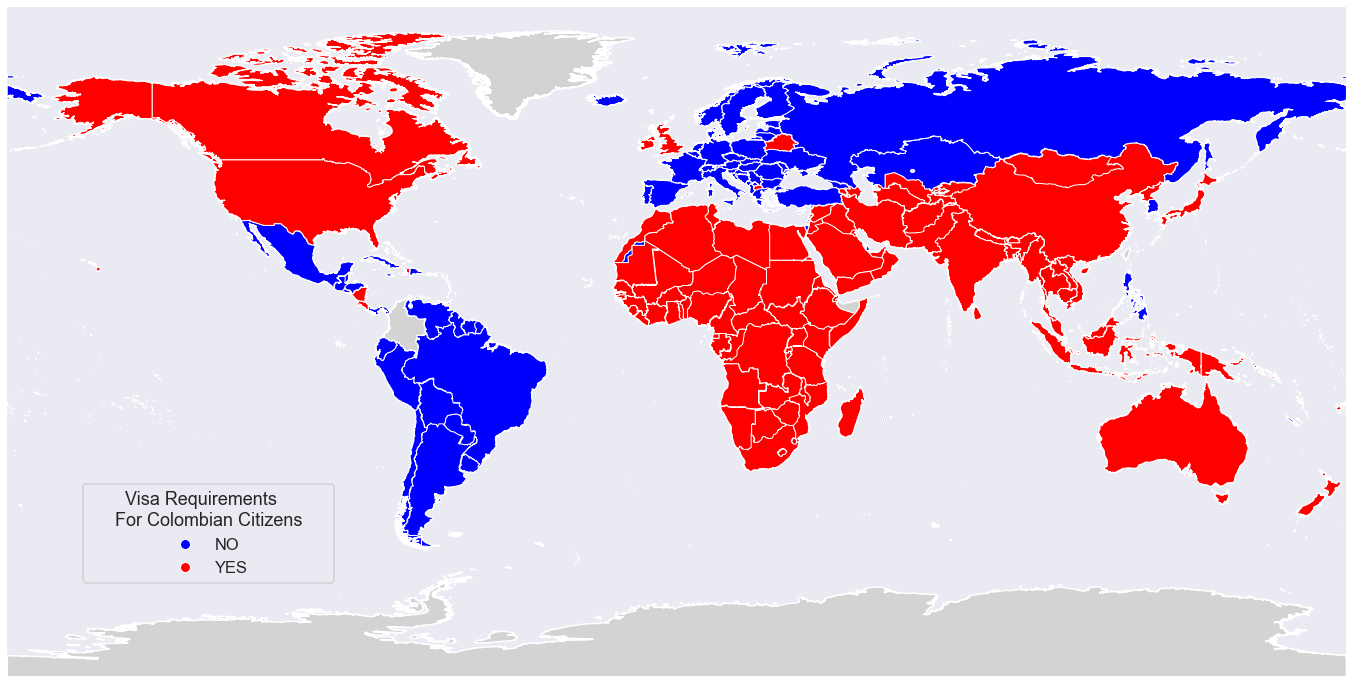

In [99]:
col_visa = countries.merge(visadf, left_on='NAME_ES', right_on='countries_matched')
cmap = mpl.colors.ListedColormap(['blue', 'red'])
mylegend = center_wrap(["Visa Requirements", "For Colombian Citizens"], cwidth=32, width=32)
MyChloropleth(mydf=col_visa, myfile='col_visa', myvar='visa_req', mylegend=mylegend, k=1, bbox_to_anchor=(0.25, 0.3),
                  edgecolor='white', facecolor='lightgray', cmap=cmap, scheme='UserDefined', bins=[0,1], legend_labels=['NO', 'YES'],
                  save=False)

Let's check whether all Franch Territories depicted have the correct visa assignment.

In [100]:
col_visa.loc[col_visa.PAIS_OR.str.contains('Francia'), ['SOVEREIGNT', 'NAME_ES', 'ADM0_A3'] + visadf.columns.to_list()]

,SOVEREIGNT,NAME_ES,ADM0_A3,PAIS,SI,NO,visa_req,visa_req_YN,PAIS_OR,countries_matched
19,France,Francia,FRA,Francia,,X,0.0,NO,Francia,Francia
35,France,San Martín,MAF,Saint Martin,X,,1.0,YES,Saint Martin (Francia),San Martín
37,Netherlands,San Martín,SXM,Saint Martin,X,,1.0,YES,Saint Martin (Francia),San Martín
168,France,Nueva Caledonia,NCL,Nueva Caledonia,,X,0.0,NO,Nueva Caledonia (Francia),Nueva Caledonia
176,France,San Pedro y Miquelón,SPM,Saint Pïerre et Miquelon,,X,0.0,NO,Saint Pïerre et Miquelon (Francia),San Pedro y Miquelón
190,France,San Bartolomé,BLM,Saint Barthélémy,X,,1.0,YES,Saint Barthélémy (Francia),San Bartolomé
199,France,Wallis y Futuna,WLF,Wallis y Futuna,,X,0.0,NO,Wallis y Futuna (Francia),Wallis y Futuna


In [101]:
visadf.loc[visadf.PAIS_OR.str.contains('Francia')]

,PAIS,SI,NO,visa_req,visa_req_YN,PAIS_OR,countries_matched
8,Francia,,X,0.0,NO,Francia,Francia
4,Guadalupe,,X,0.0,NO,Guadalupe (Francia),
8,Martinica,,X,0.0,NO,Martinica (Francia),
9,Mayotte,,X,0.0,NO,Mayotte (Francia),
10,Nueva Caledonia,,X,0.0,NO,Nueva Caledonia (Francia),Nueva Caledonia
13,Réunion,,X,0.0,NO,Réunion (Francia),
15,Saint Barthélémy,X,,1.0,YES,Saint Barthélémy (Francia),San Bartolomé
16,Saint Pïerre et Miquelon,,X,0.0,NO,Saint Pïerre et Miquelon (Francia),San Pedro y Miquelón
17,Saint Martin,X,,1.0,YES,Saint Martin (Francia),San Martín
21,Wallis y Futuna,,X,0.0,NO,Wallis y Futuna (Francia),Wallis y Futuna


Seems the ones we are missing have the same equirements as mainland France, so we are lucky and do not seem to need to do more.

<img src="../images/pics/fun/Party.jpg" alt="homework" width="500"/>

# Exercise

1. Merge the ``col_visa`` data with data from the World Development indicators
2. Explore the characteristics of the two sets of countries. Compare them in terms of income per capita, population, trade.
3. Find trade, travel, FDI data for each country in relation to Colombia. What do you find?
4. Can you provide the correlates of visa requirements for Colombia?